# Disease Classification

In this notebook, we will use text classification to automatically classify diseases based on the user's symptoms and feelings.

### Imports

In [43]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from nltk.corpus import stopwords
from wordcloud import WordCloud


## Data Load

In [18]:
datapath = ".\Data\dataset.csv"

# Read dataset into a dataframe
data = pd.read_csv(datapath)

# Check loading
print("Data loaded successfully") if data.any(axis=None) else print("Error loading data")

Data loaded successfully


In [19]:
display(data)

,Disease,User_input
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
245,Dermatitis,I have experienced a loss of interest in activ...
246,Dermatitis,The oozing and crusting on my skin have made m...
247,Dermatitis,The darkening of my skin around my eyes has ma...
248,Dermatitis,I have noticed a decline in my overall health ...


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     250 non-null    object
 1   User_input  250 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


In [74]:
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns." )
print(f"Dataset has {data['Disease'].nunique()} different diseases: {data['Disease'].unique()}.")

Dataset contains 250 rows and 2 columns.
Dataset has 5 different diseases: ['Psoriasis' 'Melanoma' 'Urticaria' 'Lupus' 'Dermatitis'].


<Axes: title={'center': 'Dataset balancing'}, xlabel='Disease'>

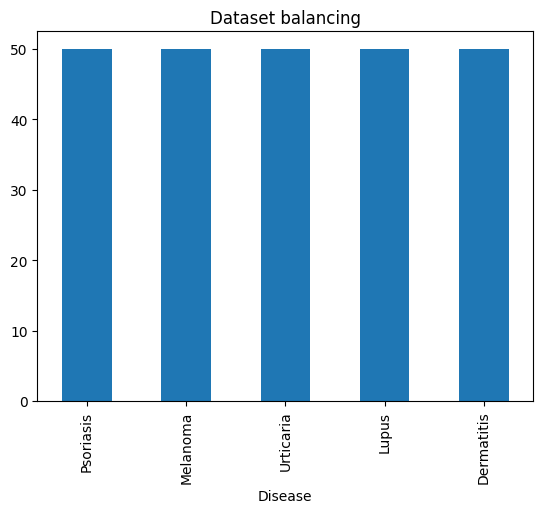

In [32]:
# Plot dataset balancing
data['Disease'].value_counts().plot(kind='bar', title='Dataset balancing')

## Model Evaluation

In [38]:
def evaluate(model, X_train, X_Test, y_train, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    train_scores = [
        "\033[1mTraining Data Results\033[0m",
        f"Accuracy Score: {accuracy_score(y_train, y_train_pred):.4f}",
        f"Specificity Score: {recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_test)):.4f}",
        f"Precision Score: {precision_score(y_train, y_train_pred, average='weighted'):.4f}",
        f"F1 Score: {f1_score(y_train, y_train_pred, average='weighted'):.4f}"
    ]

    # Test
    y_test_pred = model.predict(X_Test)
    test_scores = [
        "\033[1mTesting Data Results\033[0m",
        f"Accuracy Score: {accuracy_score(y_test, y_test_pred):.4f}",
        f"Specificity Score: {recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test)):.4f}",
        f"Precision Score: {precision_score(y_test, y_test_pred, average='weighted'):.4f}",
        f"F1 Score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}"
    ]

    column_width = max(len(s.strip()) for s in train_scores + test_scores) + 57

    # Print results
    for i in range(len(train_scores)):
        train_score = train_scores[i]
        test_score = test_scores[i]
        if test_score == test_scores[0]:
            print(f"{train_score:<{column_width + 8}}{test_score}")
        else:
            print(f"{train_score:<{column_width}}{test_score}")
    
    # Classification report train
    print("\033[1mClassification Report Train\033[0m")
    print(classification_report(y_train, y_train_pred))

    # Classification report test
    print("\033[1mClassification Report Test\033[0m")
    print(classification_report(y_test, y_test_pred))

    # Figure for confusion matrix and roc
    fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(15, 5))

    # Confusion matrix
    conf_matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred), display_labels=model.classes_)
    conf_matrix.plot(ax=ax1)

    # Roc Curve for each disease
    prediction = model.predict_proba(X_Test)
    falsepositive, truepositive, thresh = {}, {}, {}
    for i, disease in enumerate(model.classes_):
        falsepositive[disease], truepositive[disease], thresh[disease] = roc_curve(y_test, 
                                                                        prediction[:, i], 
                                                                        pos_label=disease)
    
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    for disease in model.classes_:
        ax2.plot(falsepositive[disease], truepositive[disease], label=disease)
    
    ax2.plot()

## Text Preprocessing

We will create a new column with pre-processed data to further compare the models.

In [21]:
data['User_input_preprocessed'] = data['User_input']

### Text treatment
- Remove stop words - Stop words are frequently occuring words in a language that are commonly omitted from NLP tasks due to their low significance for deciphering textual meaning.
- Remove pontuations
- Remove words with a single letter
- Transfrom all text in lower case

In [34]:
# Load english stop words using stopwords
# nltk.download('stopwords')

In [22]:
# Transform in lower case
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.lower()

In [23]:
# Remove special chars and pontuation like '.' ','
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [24]:
# Remove digits
data['User_input_preprocessed'] = data['User_input_preprocessed'].str.replace('\d+', '')

In [25]:
# Remove stop words
stop_words = stopwords.words('english')
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [26]:
# Remove words with a sigle letter
data['User_input_preprocessed'] = data['User_input_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

### Stemming & Lamitization

#### Stemming
Stemming is the process of reducing words to their word stems or roots by removing suffixes or prefixes. It uses simple rules to chop off ends of words, potentially resulting in non-real words.

#### Lemmatization
Lemmatization, on the other hand, involves reducing words to their base or canonical form, known as the lemma, by considering the morphological analysis of the word. This process involves dictionary lookup to find the lemma, making it more accurate but potentially slower than stemming.

In [93]:
#nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...


True

In [30]:
# Stemming
stemmer = nltk.stem.PorterStemmer()
data['User_input_stemmed'] = data['User_input_token_whitespace'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
data['User_input_lemmatized'] = data['User_input_token_whitespace'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [31]:
display(data)

,Disease,User_input,User_input_preprocessed,User_input_stemmed,User_input_lemmatized,User_input_token_whitespace,User_input_token_treebank,User_input_token_wordpunct
0,Psoriasis,I have been experiencing a skin rash on my arm...,experiencing skin rash arms legs torso past we...,"[experienc, skin, rash, arm, leg, torso, past,...","[experiencing, skin, rash, arm, leg, torso, pa...","[experiencing, skin, rash, arms, legs, torso, ...",experiencing skin rash arms legs torso past we...,"[experiencing, skin, rash, arms, legs, torso, ..."
1,Psoriasis,"My skin has been peeling, especially on my kne...",skin peeling especially knees elbows scalp pee...,"[skin, peel, especi, knee, elbow, scalp, peel,...","[skin, peeling, especially, knee, elbow, scalp...","[skin, peeling, especially, knees, elbows, sca...",skin peeling especially knees elbows scalp pee...,"[skin, peeling, especially, knees, elbows, sca..."
2,Psoriasis,I have been experiencing joint pain in my fing...,experiencing joint pain fingers wrists knees p...,"[experienc, joint, pain, finger, wrist, knee, ...","[experiencing, joint, pain, finger, wrist, kne...","[experiencing, joint, pain, fingers, wrists, k...",experiencing joint pain fingers wrists knees p...,"[experiencing, joint, pain, fingers, wrists, k..."
3,Psoriasis,"There is a silver like dusting on my skin, esp...",silver like dusting skin especially lower back...,"[silver, like, dust, skin, especi, lower, back...","[silver, like, dusting, skin, especially, lowe...","[silver, like, dusting, skin, especially, lowe...",silver like dusting skin especially lower back...,"[silver, like, dusting, skin, especially, lowe..."
4,Psoriasis,"My nails have small dents or pits in them, and...",nails small dents pits often feel inflammatory...,"[nail, small, dent, pit, often, feel, inflamma...","[nail, small, dent, pit, often, feel, inflamma...","[nails, small, dents, pits, often, feel, infla...",nails small dents pits often feel inflammatory...,"[nails, small, dents, pits, often, feel, infla..."
...,...,...,...,...,...,...,...,...
245,Dermatitis,I have experienced a loss of interest in activ...,experienced loss interest activities hobbies e...,"[experienc, loss, interest, activ, hobbi, enjo...","[experienced, loss, interest, activity, hobby,...","[experienced, loss, interest, activities, hobb...",experienced loss interest activities hobbies e...,"[experienced, loss, interest, activities, hobb..."
246,Dermatitis,The oozing and crusting on my skin have made m...,oozing crusting skin made feel unclean uncomfo...,"[ooz, crust, skin, made, feel, unclean, uncomf...","[oozing, crusting, skin, made, feel, unclean, ...","[oozing, crusting, skin, made, feel, unclean, ...",oozing crusting skin made feel unclean uncomfo...,"[oozing, crusting, skin, made, feel, unclean, ..."
247,Dermatitis,The darkening of my skin around my eyes has ma...,darkening skin around eyes made feel older les...,"[darken, skin, around, eye, made, feel, older,...","[darkening, skin, around, eye, made, feel, old...","[darkening, skin, around, eyes, made, feel, ol...",darkening skin around eyes made feel older les...,"[darkening, skin, around, eyes, made, feel, ol..."
248,Dermatitis,I have noticed a decline in my overall health ...,noticed decline overall health wellbeing due c...,"[notic, declin, overal, health, wellb, due, ch...","[noticed, decline, overall, health, wellbeing,...","[noticed, decline, overall, health, wellbeing,...",noticed decline overall health wellbeing due c...,"[noticed, decline, overall, health, wellbeing,..."


### Tokenization

In [29]:
# Tokenization by white space
tokenizer = nltk.tokenize.WhitespaceTokenizer()
data['User_input_token_whitespace'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))

# Tokenization by tree bank
tokenizer = nltk.tokenize.TreebankWordDetokenizer()
data['User_input_token_treebank'] = data['User_input_token_whitespace'].apply(lambda x: tokenizer.detokenize(x))

# Tokenization by word punct
tokenizer = nltk.tokenize.WordPunctTokenizer()
data['User_input_token_wordpunct'] = data['User_input_preprocessed'].apply(lambda x: tokenizer.tokenize(x))


### Bag of Words (BoW)
Is a technique in NLP that represents text as a frequency count of words in a corpus, creating a numerical vector representing the corpus

In [32]:
vectorizer = CountVectorizer(stop_words='english')
vect = vectorizer.fit_transform(data['User_input_preprocessed'])
data_bow= pd.DataFrame(vect.toarray(), columns=vectorizer.get_feature_names_out())

display(data_bow)

,abdomen,ability,accidentally,accompanied,aching,achy,actions,active,activities,adding,...,worrying,worse,worsen,worsening,worsens,worst,worthlessness,wrists,writing,wrong
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We think that to understand the symptoms is important to use n-grams

In [114]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(3, 3))
vect = vectorizer.fit_transform(data['User_input_preprocessed'])
data_bow= pd.DataFrame(vect.toarray(), columns=vectorizer.get_feature_names_out())

display(data_bow)

,abdomen itchy uncomfortable,ability comfortably freely,ability concentrate work,ability exercise enjoy,ability focus concentrate,ability perform tasks,ability relax unwind,accidentally scratch press,accidentally triggering hives,accompanied burning stinging,...,worrying constant pain,worse night facing,worse vicious cycle,worse winter air,worse winter months,worsen passing day,worsen times stress,worst night im,wrists knees pain,wrong going body
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
247,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [116]:
vectorizer = TfidfVectorizer()
vect = vectorizer.fit_transform(data['User_input_preprocessed'])
feature_names = vectorizer.get_feature_names_out()

data_tfidf = pd.DataFrame(vect.todense().tolist(), columns=feature_names)

display(data_tfidf)

,abdomen,ability,accidentally,accompanied,aching,achy,actions,active,activities,adding,...,worrying,worse,worsen,worsening,worsens,worst,worthlessness,wrists,writing,wrong
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.318275,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.357576,0.0,0.0,0.000000,0.0,...,0.0,0.28077,0.0,0.0,0.0,0.0,0.0,0.332717,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.241709,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
246,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
247,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
248,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Data Visualization

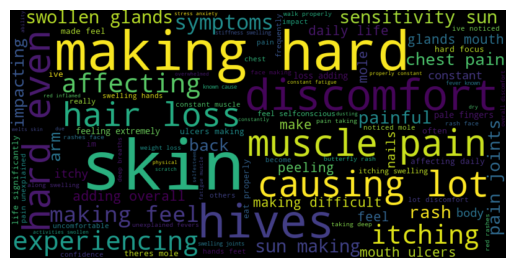

In [119]:
# General word cloud
word_list = " ".join(text for text in data['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Psoriasis

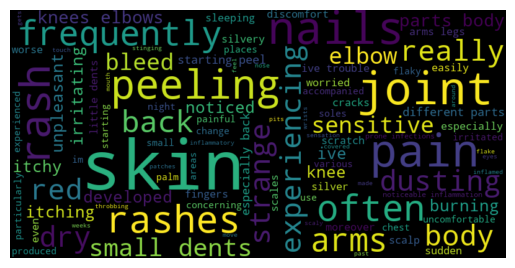

In [120]:
psoriasis = data[data['Disease'] == 'Psoriasis']

word_list = " ".join(text for text in psoriasis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Melanoma

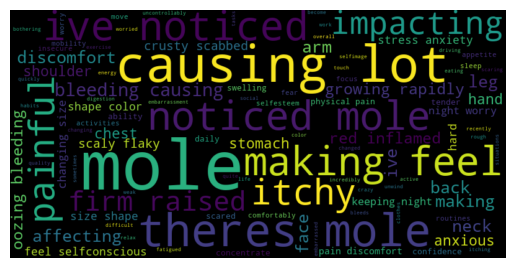

In [121]:
melanoma = data[data['Disease'] == 'Melanoma']

word_list = " ".join(text for text in melanoma['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Urticaria

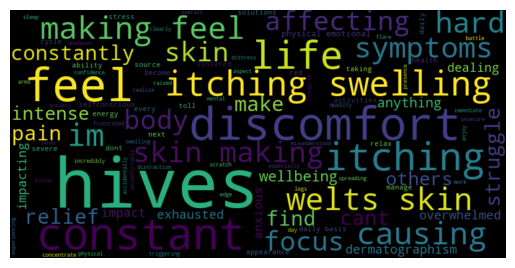

In [122]:
urticaria = data[data['Disease'] == 'Urticaria']

word_list = " ".join(text for text in urticaria['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Lupus

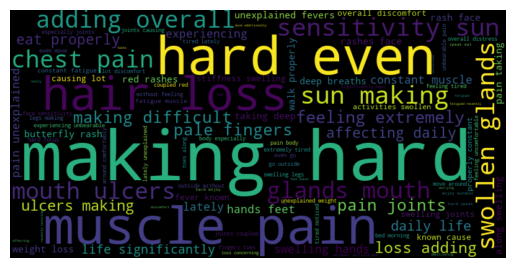

In [123]:
lupus = data[data['Disease'] == 'Lupus']

word_list = " ".join(text for text in lupus['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Dermatitis

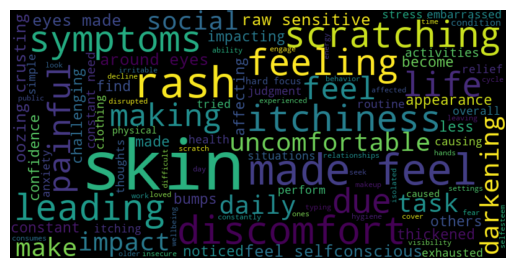

In [124]:
dermatitis = data[data['Disease'] == 'Dermatitis']

word_list = " ".join(text for text in dermatitis['User_input_preprocessed'])

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, max_words = 100).generate(word_list)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Data spliting

Once the dataset was created by the group, we decided to create a balanced dataset to make the next steps easier.

In [33]:
# Split dataset into training and testing sets
# Create a test and a train dataframe
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Check splitting
print(f"Train dataset contains {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"Test dataset contains {test.shape[0]} rows and {test.shape[1]} columns.")

Train dataset contains 200 rows and 8 columns.
Test dataset contains 50 rows and 8 columns.


In [15]:
display(train)

,Disease,User_input,User_input_preprocessed,User_input_token_whitespace,User_input_token_treebank,User_input_token_wordpunct,User_input_stemmed,User_input_lemmatized
132,Urticaria,The itching and swelling from the hives are so...,itching swelling hives intense feel like im co...,"[itching, swelling, hives, intense, feel, like...",itching swelling hives intense feel like im co...,"[itching, swelling, hives, intense, feel, like...","[itch, swell, hive, intens, feel, like, im, co...","[itching, swelling, hive, intense, feel, like,..."
225,Dermatitis,"The raw, sensitive skin from scratching has ma...",raw sensitive skin scratching made painful eng...,"[raw, sensitive, skin, scratching, made, painf...",raw sensitive skin scratching made painful eng...,"[raw, sensitive, skin, scratching, made, painf...","[raw, sensit, skin, scratch, made, pain, engag...","[raw, sensitive, skin, scratching, made, painf..."
238,Dermatitis,I have noticed that my symptoms worsen during ...,noticed symptoms worsen times stress anxiety l...,"[noticed, symptoms, worsen, times, stress, anx...",noticed symptoms worsen times stress anxiety l...,"[noticed, symptoms, worsen, times, stress, anx...","[notic, symptom, worsen, time, stress, anxieti...","[noticed, symptom, worsen, time, stress, anxie..."
119,Urticaria,The itching and swelling from the hives are ma...,itching swelling hives making irritable frustr...,"[itching, swelling, hives, making, irritable, ...",itching swelling hives making irritable frustr...,"[itching, swelling, hives, making, irritable, ...","[itch, swell, hive, make, irrit, frustrat, str...","[itching, swelling, hive, making, irritable, f..."
136,Urticaria,I feel exhausted and worn out from dealing wit...,feel exhausted worn dealing hives daily basis ...,"[feel, exhausted, worn, dealing, hives, daily,...",feel exhausted worn dealing hives daily basis ...,"[feel, exhausted, worn, dealing, hives, daily,...","[feel, exhaust, worn, deal, hive, daili, basi,...","[feel, exhausted, worn, dealing, hive, daily, ..."
...,...,...,...,...,...,...,...,...
106,Urticaria,The swelling and redness on my skin have been ...,swelling redness skin causing lot discomfort p...,"[swelling, redness, skin, causing, lot, discom...",swelling redness skin causing lot discomfort p...,"[swelling, redness, skin, causing, lot, discom...","[swell, red, skin, caus, lot, discomfort, pain...","[swelling, redness, skin, causing, lot, discom..."
14,Psoriasis,"My skin is prone to infections due to dry, fla...",skin prone infections due dry flaky patches ex...,"[skin, prone, infections, due, dry, flaky, pat...",skin prone infections due dry flaky patches ex...,"[skin, prone, infections, due, dry, flaky, pat...","[skin, prone, infect, due, dri, flaki, patch, ...","[skin, prone, infection, due, dry, flaky, patc..."
92,Melanoma,I've had a mole on my hand that is firm and ra...,ive mole hand firm raised affecting confidence...,"[ive, mole, hand, firm, raised, affecting, con...",ive mole hand firm raised affecting confidence...,"[ive, mole, hand, firm, raised, affecting, con...","[ive, mole, hand, firm, rais, affect, confid, ...","[ive, mole, hand, firm, raised, affecting, con..."
179,Lupus,I have been experiencing unbearable pain in my...,experiencing unbearable pain joints along swel...,"[experiencing, unbearable, pain, joints, along...",experiencing unbearable pain joints along swel...,"[experiencing, unbearable, pain, joints, along...","[experienc, unbear, pain, joint, along, swell,...","[experiencing, unbearable, pain, joint, along,..."


In [34]:
vectorizer = TfidfVectorizer()
vectorizer.fit(data['User_input_lemmatized'].apply(' '.join))

TfidfVectorizer()

In [35]:
#Create X and y train and test
X_train = vectorizer.transform(train['User_input_lemmatized'].apply(' '.join))
y_train = train['Disease']

X_test = vectorizer.transform(test['User_input_lemmatized'].apply(' '.join))
y_test = test['Disease']

In [36]:
display(X_train)

<200x634 sparse matrix of type '<class 'numpy.float64'>'
	with 2826 stored elements in Compressed Sparse Row format>

## Text classification

Training Data Results                                                                 Testing Data Results
Accuracy Score: 1.0000                                                                Accuracy Score: 0.9600
Specificity Score: 1.0000                                                             Specificity Score: 0.9600
Precision Score: 1.0000                                                               Precision Score: 0.9618
F1 Score: 1.0000                                                                      F1 Score: 0.9601
Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00        41
       Lupus       1.00      1.00      1.00        39
    Melanoma       1.00      1.00      1.00        43
   Psoriasis       1.00      1.00      1.00        37
   Urticaria       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       2

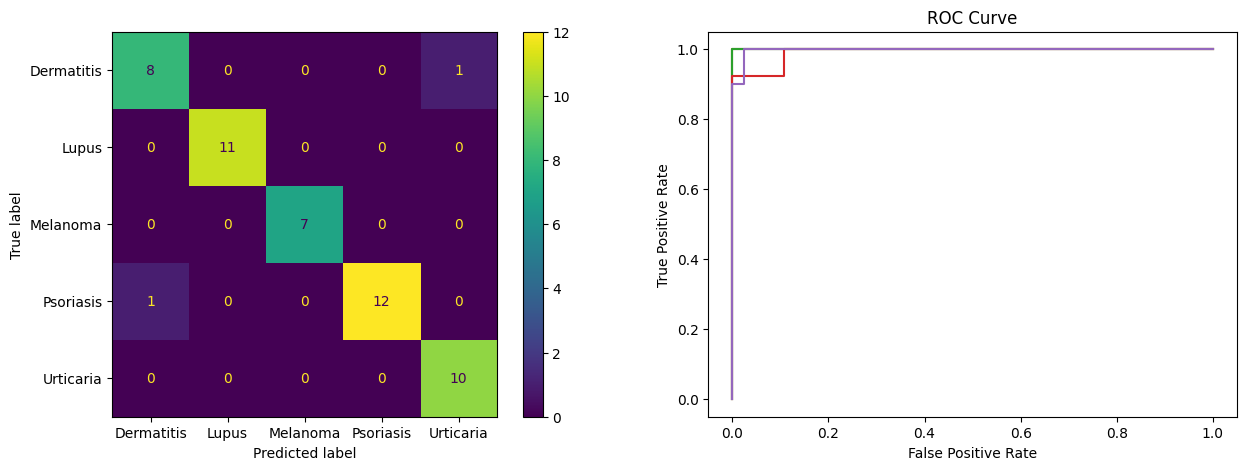

In [39]:
# Train logistic regression
lr = LogisticRegression(C=1, solver='newton-cholesky',max_iter=50)
model = lr.fit(X_train, y_train)

evaluate(model, X_train, X_test, y_train, y_test)

Training Data Results                                                                 Testing Data Results
Accuracy Score: 0.9950                                                                Accuracy Score: 0.8200
Specificity Score: 0.9950                                                             Specificity Score: 0.8200
Precision Score: 0.9951                                                               Precision Score: 0.8589
F1 Score: 0.9950                                                                      F1 Score: 0.8117
Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      0.98      0.99        41
       Lupus       1.00      1.00      1.00        39
    Melanoma       0.98      1.00      0.99        43
   Psoriasis       1.00      1.00      1.00        37
   Urticaria       1.00      1.00      1.00        40

    accuracy                           0.99       200
   macro avg       1.00      1.00      1.00       2

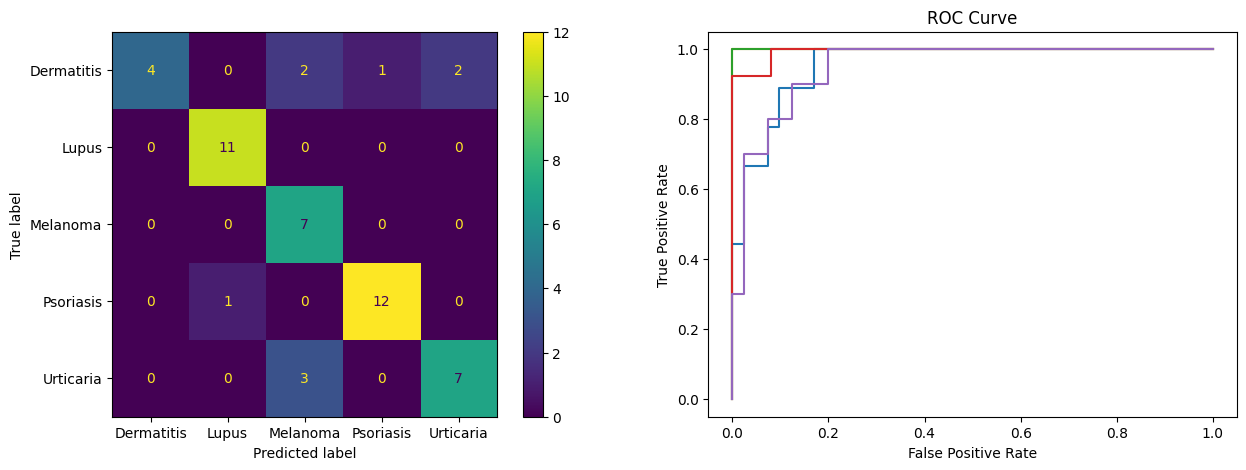

In [42]:
naive_bayes = GaussianNB(var_smoothing=0.5)
model = naive_bayes.fit(X_train.toarray(), y_train)

evaluate(model, X_train.toarray(), X_test.toarray(), y_train, y_test)

Training Data Results                                                                 Testing Data Results
Accuracy Score: 1.0000                                                                Accuracy Score: 0.9400
Specificity Score: 1.0000                                                             Specificity Score: 0.9400
Precision Score: 1.0000                                                               Precision Score: 0.9458
F1 Score: 1.0000                                                                      F1 Score: 0.9404
Classification Report Train
              precision    recall  f1-score   support

  Dermatitis       1.00      1.00      1.00        41
       Lupus       1.00      1.00      1.00        39
    Melanoma       1.00      1.00      1.00        43
   Psoriasis       1.00      1.00      1.00        37
   Urticaria       1.00      1.00      1.00        40

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       2

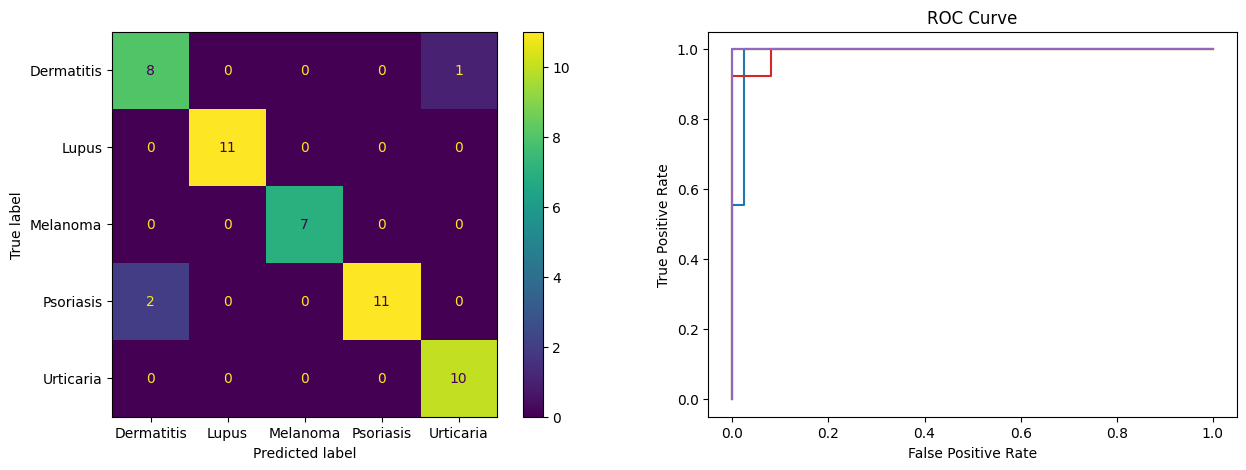

In [44]:
svm = SVC(C=5, gamma='scale',kernel='rbf', probability=True)
model = svm.fit(X_train, y_train)

evaluate(model, X_train, X_test, y_train, y_test)